#### 1. Importing required libraries

In [131]:
import pandas as pd
import numpy as np
import re
import torch
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None  # default='warn'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


####2. Preprocessing given data
> 
*   Concatenating all the food items of a specific restaurant
*   Removing all the special characters present along with converting text to lowercase










In [2]:
def preprocess():
  df = pd.DataFrame()
  df['Restaurant'] = df_init["Restaurant Name"].unique()
  df['items'] = ""

  for i in range(df_init.shape[0]):
    df.loc[df['Restaurant']==df_init["Restaurant Name"][i], 'items'] += ","
    df.loc[df['Restaurant']==df_init["Restaurant Name"][i], 'items'] += df_init['Original food Item'][i]
    
  df["preprocess"] = ""
  wordsDict = list()
  for i in range(df.shape[0]):
    df["preprocess"][i] = re.sub("[.!?\\-]",'',df["items"][i].lower())
    df["preprocess"][i] = re.sub(",",' ',df["items"][i].lower())
    words = df["preprocess"][i].split(" ")
    wordsDict.extend(w for w in words if w not in wordsDict)
  return df

####3. Reducing Dimension using Principal Component Analysis (PCA)


> Actual dimension of embedding vectors is (1,768) which is reduced to (1,2)



In [3]:
def dimension_reduction(embeddings):
  pca = PCA(2)
  df_pca = pca.fit_transform(embeddings)
  df['pointX'] = df_pca[:,0]
  df['pointY'] = df_pca[:,1]
  return df_pca

####4. Clustering of final embeddings


*   Perform clustering via KMeans and Gaussian Mixture Model (GMM)
*   Calculate Calinski-Harabasz Score
*   Plot clusters with their centroids





In [123]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import euclidean_distances
def clustering(df_pca,type,num_clusters):
  
  if type=="kmeans":
    clustering_model = KMeans(n_clusters=num_clusters)
    clustering_model.fit(df_pca)
    cluster_assignment = clustering_model.labels_
    centers = np.array(clustering_model.cluster_centers_)
  else:
    clustering_model = GaussianMixture(n_components=num_clusters)
    cluster_assignment = clustering_model.fit_predict(df_pca)
    centers = np.array(clustering_model.means_)

  cluster_coords.append(centers)
  df['cluster'] = cluster_assignment
  df['clusterX'] = centers[df['cluster'],0]
  df['clusterY'] = centers[df['cluster'],1]

  dists = euclidean_distances(centers)
  # sil_score = metrics.silhouette_score(df_pca, cluster_assignment, metric='euclidean')
  cal_score = metrics.calinski_harabasz_score(df_pca, cluster_assignment)
  # dav_score = metrics.davies_bouldin_score(df_pca, cluster_assignment)
  print("Calinski-Harabasz Score: ",cal_score)

  colors = ['b', 'g', 'c', 'k', 'm', 'y', '#673AB7','#795548','#4CAF50','#FF5722']
  markers = ['o', 'v', 's', 'X', 'x', 'p', '*', 'H', '+', '.']
  for i, l in enumerate(cluster_assignment):
    plt.plot(df_pca[i][0], df_pca[i][1], color=colors[l], marker=markers[l],ls='None')
    plt.title('Cluster Distribution')
    plt.xlabel('x-coord')
    plt.ylabel('y-coord')
    

  plt.scatter(centers[:,0], centers[:,1], marker="x", color='r')
  for i, txt in enumerate(centers):
    plt.annotate(i, (centers[i][0], centers[i][1]))
  plt.show()


####5. Calculate Intracluster Distance 


> (from every point to corresponding cluster center)





In [5]:
def calc_dist():
  dist = []
  for i in range(df.shape[0]):
    dist.append(math.sqrt((df['clusterX'][i] - df['pointX'][i])**2 + (df['clusterY'][i] - df['pointY'][i])**2))
  return dist

####6. Calculate distance between cluster centroid in consecutive iterations 

In [117]:
def calc_clusterDist(df_dist,cluster_coords):
  df_dist["Iteration1_X"] = cluster_coords[0][:,0]
  df_dist["Iteration1_Y"] = cluster_coords[0][:,1]
  df_dist["Iteration2_X"] = ""
  df_dist["Iteration2_Y"] = ""
  df_dist["Iteration2_dist"] = ""
  df_dist["Iteration3_X"] = ""
  df_dist["Iteration3_Y"] = ""
  df_dist["Iteration3_dist"] = ""

  distance = []
  for i in range(len(cluster_coords[0])):
    
    dist1 = []
    dist2 = []
    for j in range(len(cluster_coords[0])):
      dist1.append(math.sqrt((cluster_coords[0][i][0] - cluster_coords[1][j][0])**2 + (cluster_coords[0][i][1] - cluster_coords[1][j][1])**2))
      dist2.append(math.sqrt((cluster_coords[0][i][0] - cluster_coords[2][j][0])**2 + (cluster_coords[0][i][1] - cluster_coords[2][j][1])**2))
    
    one = cluster_coords[1]
    df_dist["Iteration2_X"][i] = one[dist1.index(min(dist1))][0]
    df_dist["Iteration2_Y"][i] = one[dist1.index(min(dist1))][1]
    df_dist["Iteration2_dist"] = min(dist1)

    two = cluster_coords[2]
    df_dist["Iteration3_X"][i] = two[dist2.index(min(dist2))][0]
    df_dist["Iteration3_Y"][i] = two[dist2.index(min(dist2))][1]
    df_dist["Iteration3_dist"] = min(dist2)

####7. Plot distance between cluster centroid in consecutive iterations 

In [119]:
def plot_clusterDist(df_dist):
  colors = ['b', 'g', 'c', 'k', 'm', 'y', '#673AB7','#795548','#4CAF50','#FF5722']
  markers = ['o', 'v', 's', 'X', 'x', 'p', '*', 'H', '+', '.']
  plt.subplots(figsize=(20, 5))
  for i in range(df_dist.shape[0]):
    plt.subplot(1, 3, 1)
    plt.plot(df_dist["Iteration1_X"][i], df_dist["Iteration1_Y"][i], color=colors[i], marker=markers[i],ls='None')
    plt.title('Iteration 1')
    plt.xlabel('cluster center x-coord')
    plt.ylabel('cluster center y-coord')

    plt.subplot(1, 3, 2)
    plt.plot(df_dist["Iteration2_X"][i], df_dist["Iteration2_Y"][i], color=colors[i], marker=markers[i],ls='None')
    plt.title('Iteration 2')
    plt.xlabel('cluster center x-coord')
    plt.ylabel('cluster center y-coord')

    plt.subplot(1, 3, 3)
    plt.plot(df_dist["Iteration3_X"][i], df_dist["Iteration3_Y"][i], color=colors[i], marker=markers[i],ls='None')
    plt.title('Iteration 3')
    plt.xlabel('cluster center x-coord')
    plt.ylabel('cluster center y-coord')

###**MAIN CODE**
In this project I have used 2 models to create embeddings that include Basic BERT and DistilBERT. Further for each model, embeddings have been clustered via KMeans and Gaussian Mixture Model.

Applying KMeans and GMM on same model concluded that clusters formed using either of them is same.

For embedding models, basic BERT with KMeans performed better as compared to other models as it can be inferred from centroid distances calculated.

### **BERT with KMeans**
Calinski-Harabasz Score:  ~519

No sentence-transformers model found with name /root/.cache/torch/sentence_transformers/bert-base-uncased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertFor

Iteration..... 0
Calinski-Harabasz Score:  519.9707129183338


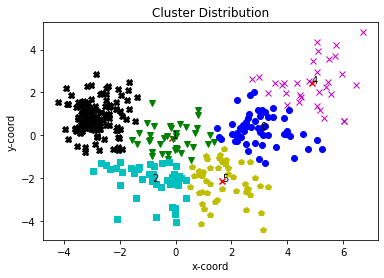

Iteration..... 1
Calinski-Harabasz Score:  519.9707439612448


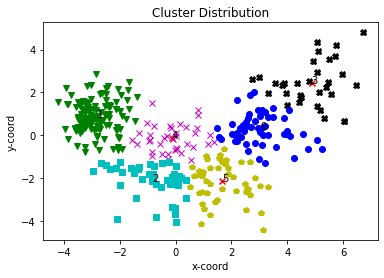

Iteration..... 2
Calinski-Harabasz Score:  519.9706712799274


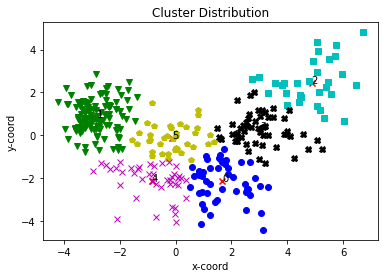

In [124]:
embedder = SentenceTransformer('bert-base-uncased')
cluster_coords = []
df_res = pd.DataFrame()
for i in range(3):
  print("Iteration.....",i)
  df_init = pd.read_csv('/content/MenuItem.csv')
  df = preprocess()
  embeddings = embedder.encode(df["preprocess"])
  
  data = dimension_reduction(embeddings)
  clustering(data,"kmeans",6)

  df_res[str(i)] = calc_dist()
  df.to_csv('result_'+str(i)+'.csv',index=False)

In [129]:
df_dist = pd.DataFrame()
calc_clusterDist(df_dist,cluster_coords)
df_dist

,Iteration1_X,Iteration1_Y,Iteration2_X,Iteration2_Y,Iteration2_dist,Iteration3_X,Iteration3_Y,Iteration3_dist
0,3.025557,0.266463,3.025556,0.266463,0.000002,3.025556,0.266463,0.000001
1,-0.129908,-0.128302,-0.129908,-0.128302,0.000002,-0.129908,-0.128302,0.000001
2,-0.846239,-2.120797,-0.846238,-2.120796,0.000002,-0.846239,-2.120796,0.000001
3,-2.837263,0.869566,-2.837263,0.869565,0.000002,-2.837262,0.869566,0.000001
4,4.879578,2.430858,4.879576,2.430858,0.000002,4.879577,2.430858,0.000001
5,1.679979,-2.151134,1.67998,-2.151133,0.000002,1.679979,-2.151133,0.000001


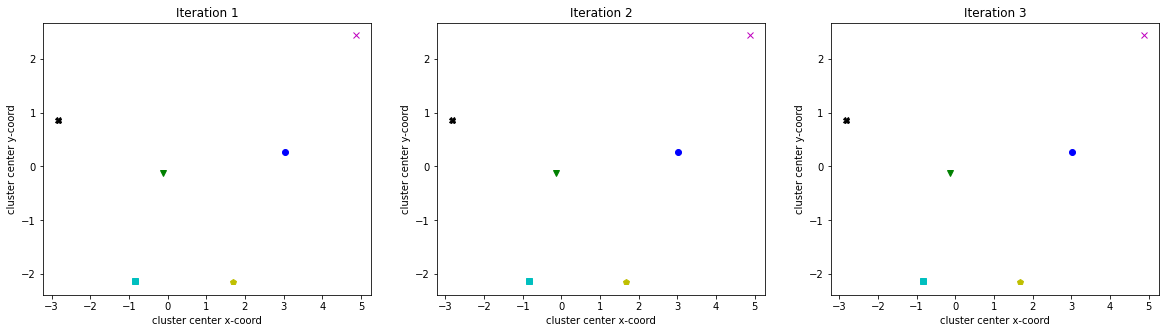

In [132]:
plot_clusterDist(df_dist)

### **BERT with GMM**
Calinski-Harabasz Score:  ~430

No sentence-transformers model found with name /root/.cache/torch/sentence_transformers/bert-base-uncased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertFor

Iteration..... 0
Calinski-Harabasz Score:  487.6324722290392


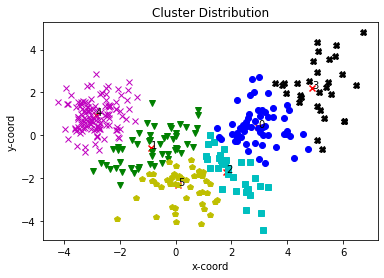

Iteration..... 1
Calinski-Harabasz Score:  429.8050764680405


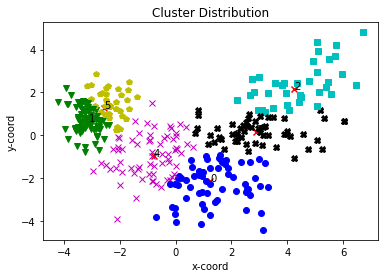

Iteration..... 2
Calinski-Harabasz Score:  499.6409292593804


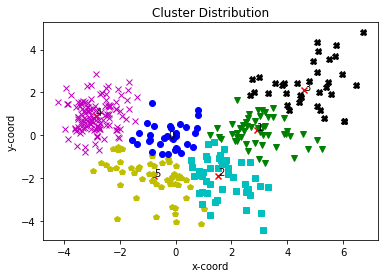

In [133]:
embedder = SentenceTransformer('bert-base-uncased')
cluster_coords = []
df_res = pd.DataFrame()
for i in range(3):
  print("Iteration.....",i)
  df_init = pd.read_csv('/content/MenuItem.csv')
  df = preprocess()
  embeddings = embedder.encode(df["preprocess"])
  
  data = dimension_reduction(embeddings)
  clustering(data,"gmm",6)

  df_res[str(i)] = calc_dist()
  df.to_csv('result_'+str(i)+'.csv',index=False)

In [134]:
df_dist = pd.DataFrame()
calc_clusterDist(df_dist,cluster_coords)
df_dist

,Iteration1_X,Iteration1_Y,Iteration2_X,Iteration2_Y,Iteration2_dist,Iteration3_X,Iteration3_Y,Iteration3_dist
0,2.959613,0.367747,2.892013,0.15336,1.166403,2.90772,0.236815,0.950779
1,-0.896562,-0.586660,-0.772503,-0.975534,1.166403,-0.26006,-0.133723,0.950779
2,1.798724,-1.707788,1.240948,-2.120365,1.166403,1.530104,-1.878535,0.950779
3,4.892754,2.196184,4.261448,2.150371,1.166403,4.616863,2.11935,0.950779
4,-2.866158,0.928034,-3.102675,0.643522,1.166403,-2.858599,0.917933,0.950779
5,0.089598,-2.307148,1.240948,-2.120365,1.166403,-0.777493,-1.917105,0.950779


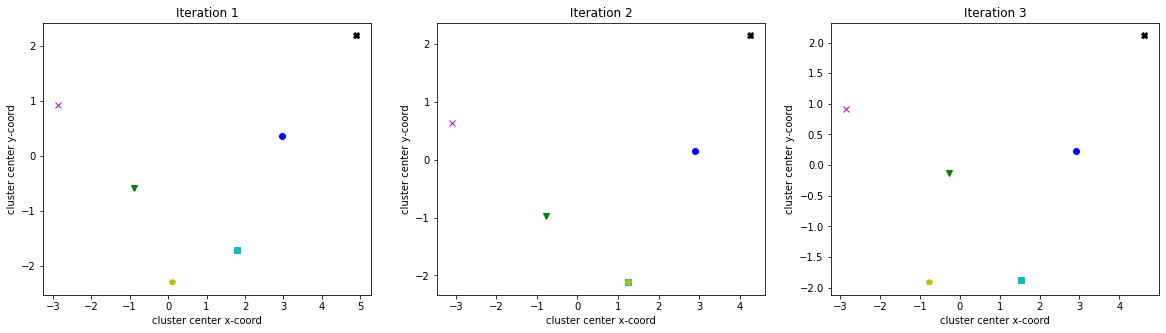

In [135]:
plot_clusterDist(df_dist)

### **DistilBERT with KMeans**
Calinski-Harabasz Score:  ~321

Iteration..... 0
Calinski-Harabasz Score:  321.0306057492808


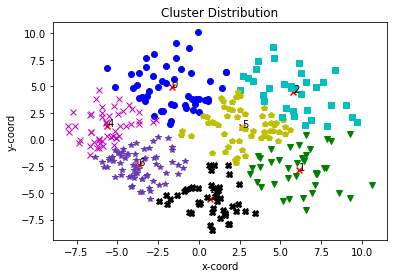

Iteration..... 1
Calinski-Harabasz Score:  321.333709175312


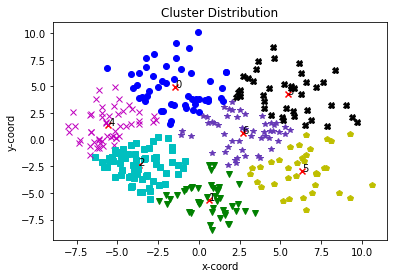

Iteration..... 2
Calinski-Harabasz Score:  321.3331904826909


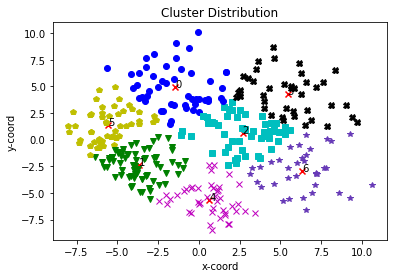

In [136]:
df_res = pd.DataFrame()
cluster_coords = []
embedder = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')
for i in range(3):
  print("Iteration.....",i)
  df_init = pd.read_csv('/content/MenuItem.csv')
  df = preprocess()
  embeddings = embedder.encode(df["preprocess"])
  
  data = dimension_reduction(embeddings)
  clustering(data,"kmeans",7)

  df_res[str(i)] = calc_dist()
  df.to_csv('result_'+str(i)+'.csv',index=False)

In [137]:
df_dist = pd.DataFrame()
calc_clusterDist(df_dist,cluster_coords)
df_dist

,Iteration1_X,Iteration1_Y,Iteration2_X,Iteration2_Y,Iteration2_dist,Iteration3_X,Iteration3_Y,Iteration3_dist
0,-1.660619,4.938169,-1.441603,4.946591,4.768372e-07,-1.441603,4.94659,0.000005
1,6.126156,-2.825543,6.309577,-2.943437,4.768372e-07,6.309578,-2.943439,0.000005
2,5.789619,4.488666,5.439349,4.308181,4.768372e-07,5.439353,4.308187,0.000005
3,0.659772,-5.565952,0.633574,-5.637412,4.768372e-07,0.633574,-5.637403,0.000005
4,-5.630832,1.238594,-5.56651,1.328947,4.768372e-07,-5.566513,1.328946,0.000005
5,2.658947,1.200608,2.672059,0.63998,4.768372e-07,2.672061,0.639979,0.000005
6,-3.697736,-2.398304,-3.697736,-2.398304,4.768372e-07,-3.697738,-2.398308,0.000005


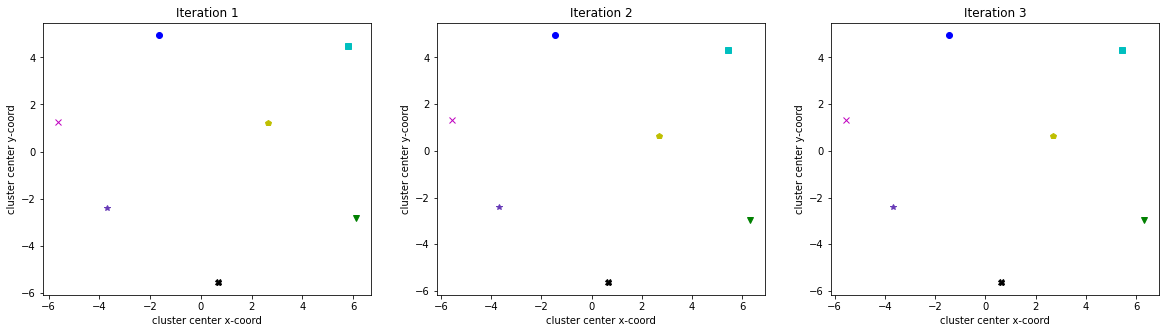

In [138]:
plot_clusterDist(df_dist)

### **DistilBERT with GMM**
Calinski-Harabasz Score:  ~250

Iteration..... 0
Calinski-Harabasz Score:  250.87537081169432


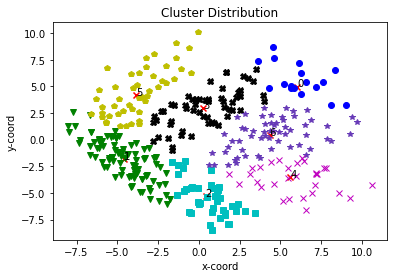

Iteration..... 1
Calinski-Harabasz Score:  223.0655586859317


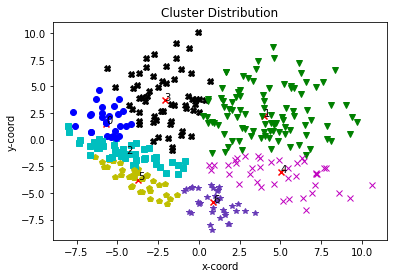

Iteration..... 2
Calinski-Harabasz Score:  259.40536069005674


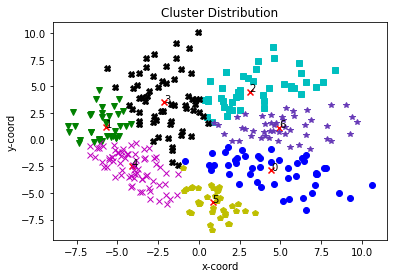

In [139]:
df_res = pd.DataFrame()
cluster_coords = []
embedder = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')
for i in range(3):
  print("Iteration.....",i)
  df_init = pd.read_csv('/content/MenuItem.csv')
  df = preprocess()
  embeddings = embedder.encode(df["preprocess"])
  
  data = dimension_reduction(embeddings)
  clustering(data,"gmm",7)

  df_res[str(i)] = calc_dist()
  df.to_csv('result_'+str(i)+'.csv',index=False)

In [140]:
df_dist = pd.DataFrame()
calc_clusterDist(df_dist,cluster_coords)
df_dist

,Iteration1_X,Iteration1_Y,Iteration2_X,Iteration2_Y,Iteration2_dist,Iteration3_X,Iteration3_Y,Iteration3_dist
0,6.009606,4.973444,3.976732,2.210074,1.851529,3.111339,4.504892,0.939591
1,-4.620818,-1.819196,-4.429541,-1.266783,1.851529,-4.100313,-2.489185,0.939591
2,0.409479,-5.310327,0.871154,-5.878291,1.851529,0.840584,-5.896052,0.939591
3,0.270652,2.946757,-2.103511,3.685828,1.851529,-2.126309,3.496302,0.939591
4,5.591949,-3.487184,5.035766,-3.008898,1.851529,4.419834,-2.873405,0.939591
5,-3.852131,4.213006,-2.103511,3.685828,1.851529,-2.126309,3.496302,0.939591
6,4.329697,0.392500,3.976732,2.210074,1.851529,4.91707,1.125865,0.939591


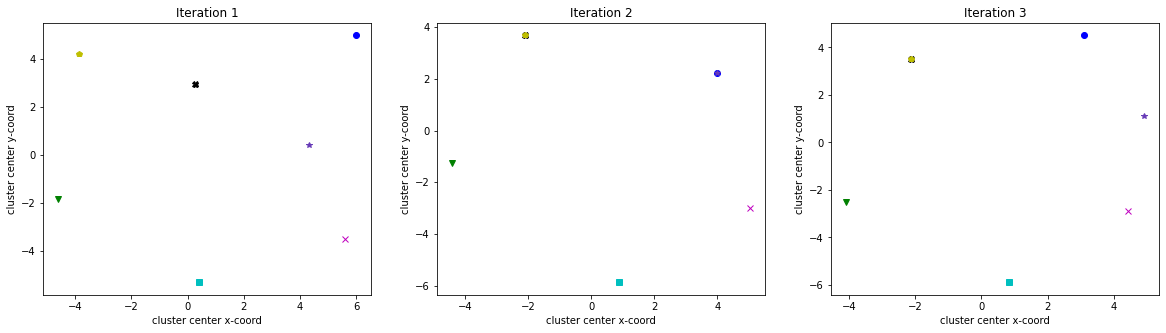

In [141]:
plot_clusterDist(df_dist)